# Homework 8.4

> Dept.ATM  
> Name: Hugo ChunHo Lin  
> Student Number: 109601003

Please generate a thermal diagram for a convective rainfall case and estimate CAPE, CIN, K-index, characterize the conditions of the case. Please select the historical event by yourself. The sounding data can be downloaded from 大氣水文資料庫。  
Please mark your student ID and date (year, mon, day, hour) in the title of the diagram.

CAPE: 1881.687457962888 joule / kilogram
CIN: -3.3757587670558733 joule / kilogram
K-index: 37.8 degree_Celsius


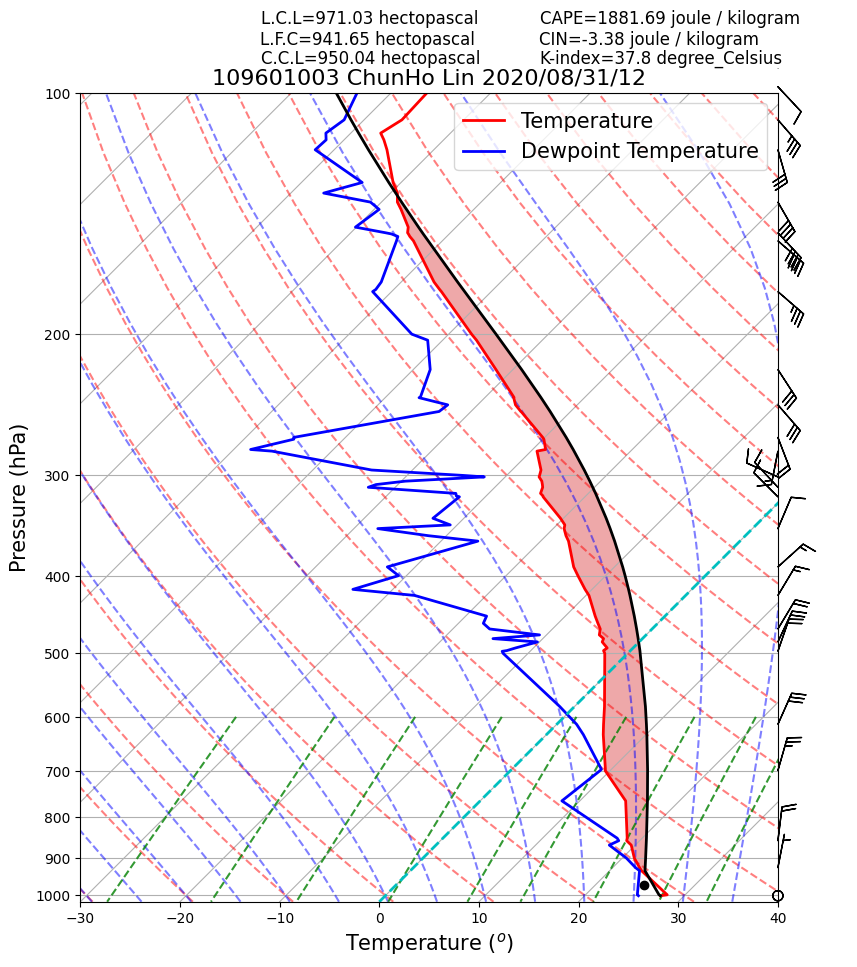

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import metpy.calc as mpcalc
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units
from metpy.calc import lcl , lfc

df=pd.read_csv('./data/202008_upair.txt',sep='\s+',header=11)
df=df[1:]

df['yyyymmddhh']=df['yyyymmddhh'].astype('int').astype('str')

filt=(df['stno']=='466920')&(df['yyyymmddhh']=='2020083112')  

p=df.loc[filt,'Press'].values * units.hPa
T=df.loc[filt,'Tx'].values * units.degC
Td=df.loc[filt,'Td'].values * units.degC
rh=df.loc[filt,'RH'].values

wind_speed = df.loc[filt,'Ws'].values * units.knots *1.94384449                         #note:unit
wind_dir = df.loc[filt,'Wd'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

fig = plt.figure(figsize=(9,11))

#add_metpy_logo(fig, 120, 50)
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot.

skew.plot(p, T, 'r', lw=2, label='Temperature')
skew.plot(p, Td, 'b', lw=2, label='Dewpoint Temperature')
skew.plot_barbs(p[::3], u[::3], v[::3], y_clip_radius=0.03)  #[::3] 每3點取資料
skew.ax.set_ylim(1020, 100)
skew.ax.set_xlim(-30, 40)


# Calculate LCL height and plot as black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])          #LCL     
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, prof, Td)
skew.shade_cape(p, T, prof)

#計算CAPE CIN K-index
CAPE,CIN= mpcalc.cape_cin(p, T, Td, prof)                                           #計算CAPE & CIN & K-index
K=mpcalc.k_index(p, T, Td)
print("CAPE:", CAPE)
print("CIN:", CIN)
print("K-index:", K)

#計算LFC、CCL
ccl_p, ccl_t, t_c = mpcalc.ccl(p, T, Td)                                #CCL
lfc_p, lfc_t = lfc(p, T, Td)


# An example of a slanted line at constant T -- in this case the 0
# isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
#skew.plot_dry_adiabats()
#skew.plot_moist_adiabats()
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10)*units.K, alpha=0.5, color='orange')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5)*units.K, alpha=0.5, color='g')
skew.plot_mixing_lines()

# Show the plot

CAPE='CAPE=' + str(round(CAPE,2))
CIN = 'CIN=' + str(round(CIN,2))
K = 'K-index=' + str(round(K,1))
CCL = 'C.C.L=' + str(round(ccl_p,2))
LCL = 'L.C.L=' + str(round(lcl_pressure,2))
LFC = 'L.F.C=' + str(round(lfc_p,2))


plt.text(-72,82,CAPE,fontsize=12)
plt.text(-70,87,CIN,fontsize=12)    
plt.text(-68,92,K,fontsize=12)
plt.text(-100,82,LCL,fontsize=12)
plt.text(-98,87,LFC,fontsize=12)
plt.text(-96,92,CCL,fontsize=12)

plt.title(f'109601003 ChunHo Lin 2020/08/31/12', size=16)
plt.xlabel("Temperature ($^o$)", fontsize=15)  #$^o$ 上標符號'度'
plt.ylabel("Pressure (hPa)", fontsize=15)
plt.legend(loc='upper right', fontsize=15)

plt.show()